# A simple guide to how turn SAC to WAV files 

## What you will need to run this notebook

The usual suspects:

    Anaconda
    obspy
    obspyDMT
    numpy, scipy, cartopy, ...

The extras:
    
    SoundFile
    

## Useful links
    
   **Websites for finding earthquakes, networks and stations:**
    - http://www.fdsn.org/networks/
    - http://ds.iris.edu/wilber3/find_event
    
   **Understanding network codes:**
    - https://ds.iris.edu/ds/nodes/dmc/tools/data_channels/#???
    - https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/
    
   **How to quickly download earthquakes:**
    - https://github.com/kasra-hosseini/obspyDMT
    
   **Learn more about python, jupyter notebooks and obspy:**
    - http://seismo-live.org/
    
   **How to install Anaconda:**
    - https://docs.anaconda.com/anaconda/install/mac-os/
    
   **What we are using to export the waveforms to WAV files:**
    - https://pysoundfile.readthedocs.io/en/latest/

ATTENTION 1: 
It you have a "%%capture" at the top of the cell no output will be shown. If you are suspicious that something is going terribly wrong you can comment out this line and see the whole output again.

ATTENTION 2:
Basemap is deprecated in favor of the Cartopy project. 

## Import 

You usually do not change this part.

In [17]:
# solve issue with autocomplete
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import sys
import time
import glob
from IPython import display

from soundfile import SoundFile
from natsort import natsorted

import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
from obspy import read, Trace
from obspy.signal.tf_misfit import plot_tfr

# the file src_sac2wav contains written functions for exporting sac to wav files
from src_sac2wav import *

## Input

Here you can decide what you want to download (start/endtime, samplingrate, etc), where to save the data. NOTE: So far I only set up this scrip for event based downloads. At a later stage we can extend it to daywise downloads.

In [11]:
# ==============
# DOWNLOAD input 
# ==============

save_path = 'F:\github\sac2wav\github\IM_NV31_Event_2021_03_04'

# Choose between "event" and "continuous" or "day" mode.
# When you are choosing "continuous" or "day" mode, day files will be downloaded regardless of the mode. 
# In continuous mode the day files are later merged to one long trace and exported as WAV. 
mode = 'event'

# Does not download anything but just gives you a table of available events in the timespan you define in start_time/end_time
event_info = False

start_time = '2021-03-03'
end_time = '2021-03-05'

# preset and offset make only sense in event mode, will not be used with continuous or day mode!
preset = 300  # in [SEC] default: 0; put None if you want to use default values
offset = 7200  # default: 1800 for event-based mode and 0 for continuous mode

min_mag = '8.0'
max_mag = '10'

samplingrate = 40  # or None 
waveform_format = 'sac'  # or mseed 

event_catalog = 'NEIC_USGS'
data_source = 'all'  # all or RESIF

network = 'IM'
station = 'NV31'
channel = '*'

# ATTENTION!! If this is set to TRUE and the datapath is found, delete it before running obspyDMT
reset = False

# parallel request is on default with 4 cores 
parallel_request = True

# parallel processing is on default with 4 cores
parallel_process = True

# ================
# SAC to WAV input 
# ================

# if poly_wav set to True then 4 channels (xyzh) are exported in one wav file;
# if set to False four seperate wav files for each channel are exported
# if h not present for landstation a zero trace is exportet instead (for single and ploy wav files)
poly_wav = True

# specify event or the continuous folder
# '20121207_081823.a' or 'continuous*' or 'continuous01' or '*_*.*' (for events)
main_folder = '*_*.*'

# specify processing folder
# 'processed' or 'raw'
proc_folder = 'processed'  

station_selection = '*'  # or "RR05" or '*' or ['PL08', 'BIG2'] 

# WAV settings
framerate = 48000
bitrate = 'PCM_24'

# generates automatically plots of SAC files in WAV folder
plot_waveforms = True

# =========
# Post-proc
# =========

save_figs = True

plot_instrument_response = True  # if save_figs = True -> automatically saves in plot folder, otherwise will not be saved

filtering = True
filter_type = 'bandpass'  # or 'lowpass', 'highpass'
freqmin =  1/50 # Hz
freqmax = 1     # Hz

In [12]:
wav_save, save_fig_path = generate_output_folders(mode, save_path, save_figs)

## Download the data

Generate the obspyDMT command first:

In [5]:
##### here the input from above is put together for obspyDMT 
execute_DMT = f'obspyDMT --datapath {save_path} --min_date {start_time} --max_date {end_time}'\
              f' --waveform_format {waveform_format} --data_source {data_source}'\
              f' --instrument_correction'

if mode == 'event':
    execute_DMT = execute_DMT + f' --min_mag {min_mag} --max_mag {max_mag}'\
                                f' --event_catalog {event_catalog}'

elif mode == 'continuous' or mode == 'day':
    execute_DMT = execute_DMT + f' --continuous '

else:
    sys.exit(f'Mode: {mode} not implemented. Forced exit!')

# if samplingrate is not None then add the sampling rate modifier otherwise it 
# should not change the sampling rate of the waveforms


if station == '*':
    # This means all channels are considered but some datacentres don't like the wildcard
    pass
elif station != '*':
    execute_DMT = execute_DMT + f' --sta {station}'

if channel == '*':
    pass
elif channel != '*':   
    execute_DMT = execute_DMT + f' --cha {channel}'

if network == '*':
    pass
elif network != '*':
    execute_DMT = execute_DMT + f' --net {network}'

if preset:
    execute_DMT = execute_DMT + f' --preset {preset}'

if offset:
    execute_DMT = execute_DMT + f' --offset {offset}'

if samplingrate: 
    execute_DMT = execute_DMT + f' --sampling_rate {samplingrate}'

if parallel_request:
    execute_DMT = execute_DMT + f' --req_parallel --req_np 4'

if parallel_process:
    execute_DMT = execute_DMT + f' --parallel_process --process_np 4'

if event_info:
    execute_DMT = execute_DMT + f' --event_info'
    
if reset:
    execute_DMT = execute_DMT + f'  --reset'
        
print(f'Executing following command in the next cell:\n\n{execute_DMT}')

Executing following command in the next cell:

obspyDMT --datapath github/IM_NV31_Event_2021_03_04 --min_date 2021-03-03 --max_date 2021-03-05 --waveform_format sac --data_source all --instrument_correction --min_mag 8.0 --max_mag 10 --event_catalog NEIC_USGS --sta NV31 --net IM --preset 300 --offset 7200 --sampling_rate 40 --req_parallel --req_np 4 --parallel_process --process_np 4


Attention! Only execute the next line if you want to download or update your dataset. If you just want to plot or export some specific data you already downloaded then you do not have to execute the next line!

In [6]:
!{execute_DMT}

--------------------------------------------------------------------------------
		   obspyDMT (obspy Data Management Tool)

	Python Toolbox for Retrieving, Processing and Management of
			Large Seismological Datasets

:copyright:
The ObsPy Development Team (devs@obspy.org)

Developed by Kasra Hosseini
email: kasra.hosseinizad@earth.ox.ac.uk

:license:
GNU General Public License, Version 3
(http://www.gnu.org/licenses/gpl-3.0-standalone.html)
--------------------------------------------------------------------------------


obspyDMT primary mode: event_based


Waveforms will be retrieved from:
BGR,ETH,EMSC,GEONET,GFZ,ICGC,INGV,IPGP,IRIS,ISC,KNMI,KOERI,LMU,NCEDC,NIEP,NOA,ODC,ORFEUS,RESIF,RASPISHAKE,SCEDC,TEXNET,UIB-NORSAR,USGS,USP



Event(s) are based on:	NEIC_USGS
#Divisions: 0

Assembling 1 xml files...
1,[1/1-3/3] -- IRIS -- saving waveform for: IM.NV31..BHZ  ---> DONE
[1/1-3/3] -- IRIS -- saving response for: IM.NV31..BHZ  ---> DONE
[1/1-1/3] -- IRIS -- saving waveform for: IM.NV31

'clear' is not recognized as an internal or external command,
operable program or batch file.
f:\anaconda\envs\pysound\lib\site-packages\obspy\clients\arclink\__init__.py:178: ObsPyDeprecationWarning: The ArcLink protocol will be deprecated in the near future. Please, use the client contacting the routing service provided by EIDA: https://docs.obspy.org/packages/obspy.clients.fdsn.html#basic-routing-clients-usage
  warnings.warn(msg, category=ObsPyDeprecationWarning)
f:\anaconda\envs\pysound\lib\site-packages\obspy\clients\arclink\__init__.py:178: ObsPyDeprecationWarning: The ArcLink protocol will be deprecated in the near future. Please, use the client contacting the routing service provided by EIDA: https://docs.obspy.org/packages/obspy.clients.fdsn.html#basic-routing-clients-usage
  warnings.warn(msg, category=ObsPyDeprecationWarning)
f:\anaconda\envs\pysound\lib\site-packages\obspy\clients\arclink\__init__.py:178: ObsPyDeprecationWarning: The ArcLink protocol will be deprecated in 


check the availability: TEXNET
ERROR: availability -- TEXNET -- No data available for request.
Detailed response of server:



check the availability: UIB-NORSAR
ERROR: availability -- UIB-NORSAR -- No data available for request.
Detailed response of server:



check the availability: USGS
ERROR: availability -- USGS -- The current client does not have a station service.

check the availability: USP
ERROR: availability -- USP -- No data available for request.
Detailed response of server:




availability for event: 1/1 ---> DONE
Time for checking the availability: 0:00:25.423244
[INFO] requested data sources:
IRIS 


DONE with Event: 20210304_192833.a
Time: 0:00:09.564970
[LOCAL] Path:
F:\github\sac2wav\github/IM_NV31_Event_2021_03_04\20210304_192833.a
[INFO] update station_event file...


All 3 processes are finished...


obspyDMT main program has finished!

F:\github\sac2wav\github/IM_NV31_Event_2021_03_04
* Total time of execution: 0:00:39 (h:m:s)




## Access downloaded data and save as WAV files

### Reading station information

No visible output generated with %%caputre.

Attnetnion: In some cases there might be a gap in data and the %%capture suppress the Warning messages! If you want to see them then comment the first line of the next cell.

In [7]:
%%capture

# find read_station_information function in src_sac2wav.py if you want to know what is happening inside this function
df = read_station_information(save_path, main_folder)
# a data frame (df) is generate with all station event information for your current download

Here, you can look at the data frame:

In [8]:
print(df)

  net station location channel   stalat       stalon  staele None  cata  \
0  IM    NV31              BHE  38.4328  -118.155403  1509.0  0.0  IRIS   
1  IM    NV31              BHN  38.4328  -118.155403  1509.0  0.0  IRIS   
2  IM    NV31              BHZ  38.4328  -118.155403  1509.0  0.0  IRIS   

                mode     evlat      evlon  evdep  mag  None   None  10 None  
0  20210304_192833.a  -29.7228  -177.2794  28.93  8.1  90.0    0.0  10       
1  20210304_192833.a  -29.7228  -177.2794  28.93  8.1   0.0    0.0  10       
2  20210304_192833.a  -29.7228  -177.2794  28.93  8.1   0.0  -90.0  10       


## Plot station event distribution

<IPython.core.display.Javascript object>


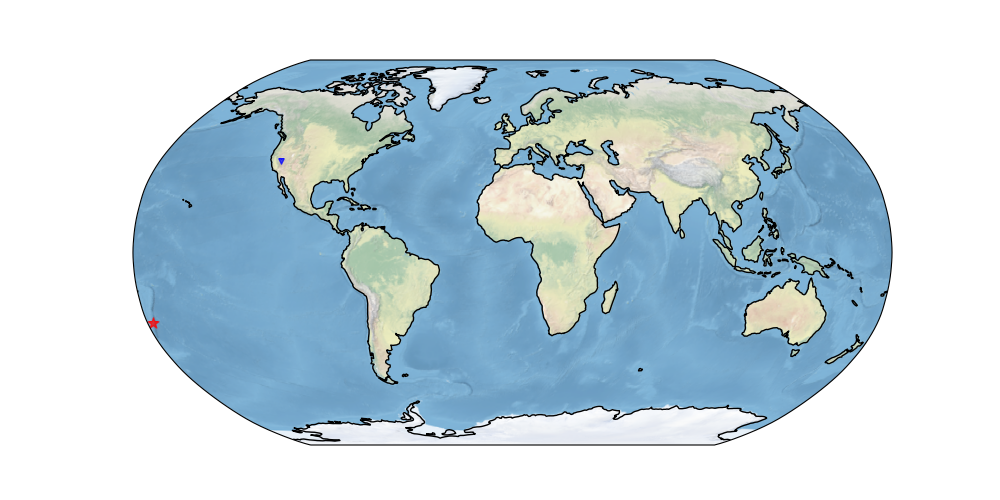

In [9]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
ax.stock_img()
ax.coastlines()

df1 = df.drop_duplicates(['stalon','stalat'])
ax.scatter(df1['stalon'].astype(float), df1['stalat'].astype(float), c='b', marker='v', s=15, alpha=0.7,  transform=ccrs.PlateCarree())

if mode == 'event':
    df2 = df.drop_duplicates(['evlon','evlat'])
    ax.scatter(df2['evlon'].astype(float), df2['evlat'].astype(float), c='r', marker='*', s=65, alpha=0.7, transform=ccrs.PlateCarree())

if save_figs:
    plt.savefig(os.path.join(save_fig_path, 'station_event_map.png'), dpi=300)
plt.show()

### Converting to WAV

Even if you can download all possible channels (e.g. Water current, temperature, etc... see also here: https://ds.iris.edu/ds/nodes/dmc/tools/data_channels/#VOC) only seismometer channels are exported to WAV files. Only channels starting with:

    XX E       Extremely Short Period  ≥ 80 to < 250< 10 sec
    XX S       Short Period  ≥ 10 to < 80< 10 sec
    
    H       High Broad Band ≥ 80 to < 250≥ 10 sec
    B       Broad Band≥ 10 to < 80≥ 10 sec
    M       Mid Period> 1 to < 10LLong Period≈ 1
    L	    Long Period	≈ 1
    V       Very Long Period≈ 0.1
    
    XX U       Ultra Long Period≈ 0.01
    XX R       Extremely Long Period≥ 0.0001 to < 0.001

will be considered for converting for WAV files. There are even longer/shorter period channels which can be added at a later stage if desired.

For instance

    VOC measures water current
    VKI measures inside Temperature
and

    the “LOG” channel for the console log
    the “SOH” channel for the main state of health channel

are skipped. 

In [20]:
# %%capture
stars = '*'*len('Mode: ' + mode)
print(f'{stars}')
print(f'Mode: {mode}')
print(f'{stars}')

if mode == 'continuous':
    # does generate continuous wav files;
    # ATTNENTION uses all continuous* folders in save_path
    export_continuous(df, poly_wav, proc_folder, station_selection, 
                      framerate, bitrate, save_path, wav_save, plot_waveforms)

elif mode == 'event':
    # genereates wav files containing specific events
    export_event(df, poly_wav, main_folder, proc_folder, station_selection, 
                 framerate, bitrate, save_path, wav_save, plot_waveforms)

elif mode == 'day':
    # genereates wav files containing specific days

    export_day(df, poly_wav, proc_folder, station_selection, 
                 framerate, bitrate, save_path, wav_save, plot_waveforms)
else: 
    sys.exit(f'Mode: {mode} does not exist or is not implemented. Forced exit!')

***********
Mode: event
***********
Searching SACs in 20210304_192833.a
	Reading for NV31
		Searching in ['BHE', 'BHN', 'BHZ', 'BDH']
			Found NV31.BHE
			Found NV31.BHN
			Found NV31.BHZ
list index out of range 
No station available in:
F:\github\sac2wav\github\IM_NV31_Event_2021_03_04\20210304_192833.a\processed\*NV31*BDH*
			Adding a zero trace for the hydrophone channel...


F:\github\sac2wav\src_sac2wav.py:576: RuntimeWarning: invalid value encountered in true_divide
  data = collect_tr[:,i] / abs(collect_tr[:,i]).max()


RuntimeError: Error opening 'F:\\github\\sac2wav\\github\\IM_NV31_Event_2021_03_04\\WAV_events\\NV31_all_channels_2021-03-04T19:23:33.200000Z.WAV': System error.

## Plot a particular station that was already downloaded

In [26]:
import soundfile as sf
print(sf._libname)

libsndfile64bit.dll


In [22]:
glob.glob('F:\\github\\sac2wav\\github\\IM_NV31_Event_2021_03_04\\WAV_events\\*')

['F:\\github\\sac2wav\\github\\IM_NV31_Event_2021_03_04\\WAV_events\\NV31_20210304_192833_processed_0DH_BHN_BHE_BHZ.png',
 'F:\\github\\sac2wav\\github\\IM_NV31_Event_2021_03_04\\WAV_events\\sampling_rate_information.txt']

In [ ]:
uniq_sta = df['station'].unique()
uniq_cha = df['channel'].unique()
uniq_modes = df['mode'].unique()
print(f'Available stations:\n{uniq_sta}')
print(f'Available channels:\n{uniq_cha}')
print(f'Available modes/events:\n{uniq_modes}')

In [ ]:
# you could also define another folder/event that was previously downloaded, default here is save_path
path_to_folder = save_path

# specify event
event = 'continuous1'  # or "continuous01"

# specify folder
folder = 'processed'  # 'processed' or "raw"

# station
sta = 'PL08'

cha = 'B*'

### Seismograms and Spectrum

Here you plot all available channels of this one stations. Grouped stations and channels are automatically saved when converting from SAC to WAV.

In [ ]:
chans = glob.glob(os.path.join(path_to_folder, event, folder, f'*{sta}*{cha}*'))
chans.sort()

fig, axs = plt.subplots(len(chans),2, figsize=(10, 3*len(chans)), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 1, wspace=0.5)

j = 0
for i, trace in enumerate(chans):

    tr = read(trace)[0]
    if filtering:
        tr.filter(filter_type, freqmin=freqmin, freqmax=freqmax)
        # tr.filter('highpass',  freqmin=1/50, freqmax=50)
    try:
        data = tr.data / abs(tr.data).max()
        axs[j].plot(tr.times(), data)
        axs[j].set_title(tr.stats.channel, weight='bold')
        axs[j].set_xlabel('samples')
        axs[j].set_ylabel('normalized')

        axs[j+1].magnitude_spectrum(data, Fs=tr.stats.sampling_rate, color='C2', alpha=0.5)
        axs[j+1].set_title(f'Spectrum: {tr.stats.channel}', weight='bold')
        axs[j+1].set_xscale('log')
        axs[j+1].set_xlim(0.001, 30)

        j += 2
    except Exception as exp:
        axs[j].set_title(tr.stats.channel, weight='bold')
        axs[j].set_xlabel('samples')
        axs[j].set_ylabel('normalized')
        axs[j+1].set_title(f'Spectrum: {tr.stats.channel}', weight='bold')
        axs[j+1].set_xscale('log')
        axs[j+1].set_xlim(0.001, 30)
        j += 2
        continue

if save_figs:
    plt.savefig(os.path.join(save_fig_path, f'{sta}_{event}_{folder}_all_channels.png'), dpi=300)
plt.show()

A spectrogram my take some time depending on the length of the trace and other settings. Hence for now it is done separately.

### Spectrogram

Change following settings

- fmin    
  minimal frequency to be analyzed
- fmax    
  maximal frequency to be analyzed
- nf      
  number of frequencies (will be chosen with logarithmic spacing)
- w0    
  parameter for the wavelet, tradeoff between time and frequency resolution
- fft_zero_pad_fac      
  integer, if > 0, the signal is zero padded to nfft = next_pow_2(len(st)) * fft_zero_pad_fac to get smoother spectrum in the low frequencies
- clim
  limits of the colorbars
- cmap
  colormap for TFEM/TFPM, either a string or matplotlib.cm.Colormap instance
  Check here:
  https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [ ]:
%%capture
# dt time step between two samples in st (automatically set)
fmin = 0.01
fmax = 1.
w0=10.
nf=64
fft_zero_pad_fac=4
cmap = 'inferno'

chans = glob.glob(os.path.join(path_to_folder, event, folder, f'*{sta}*{cha}*'))
chans.sort()
for trace in chans:
    print(f'Plotting {trace}')
    tr = read(trace)[0]
    plot_tfr(tr.data, 
             dt=tr.stats.delta, 
             fmin=fmin, 
             fmax=fmax, 
             w0=w0, 
             nf=nf, 
             clim=np.mean(tr.data)+np.std(tr.data),
             cmap=cmap,
             fft_zero_pad_fac=fft_zero_pad_fac)
    if save_figs:
        plt.savefig(os.path.join(save_fig_path, f'{sta}_{tr.stats.channel}_spec_{event}_{folder}.png'), dpi=300)

### Instrument response

In [ ]:
from obspy import read, read_inventory

chans = glob.glob(os.path.join(path_to_folder, event, folder, f'*{sta}*{cha}*'))
chans.sort()
inresp = glob.glob(os.path.join(path_to_folder, event, 'resp', f'*{sta}*{cha}*'))
inresp.sort()

pre_filt = [0.001, 0.005, 45, 50]
            
for i, trace in enumerate(chans):
    st = read(trace)
    tr = st[0]
    inv = read_inventory(inresp[i])
    
    if save_figs:
        out_save = os.path.join(save_fig_path, f'{sta}_{tr.stats.channel}_instrument_response_{event}_{folder}.png')
        tr.remove_response(inventory=inv, pre_filt = pre_filt, output="DISP", plot=out_save)
    else:
        tr.remove_response(inventory=inv, pre_filt= pre_filt,output="DISP", plot=True)      